In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from estimation_fct import *

In [2]:
# Load model
from model import ModelClass

model = ModelClass() 

par = model.par
sol = model.sol
sim = model.sim

model.solve()
model.simulate()

In [3]:
# Prepare data
mean, weights, moments = prepare_data(par)

In [4]:
# Prepare SMM
theta_names = ("beta", "sigma", "gamma", "mu", "r_s", "r_a")
theta_init = np.array([0.976, 1.026, 4.723, 7.887, 0.015, 0.009])

# Original bounds
orig_bounds = [(0.0, 1.0),   # beta
               (0.1, 6.0),   # sigma
               (0.1, 10.0),  # gamma
               (0.0, 10.0),  # mu
               (0.0, 0.02),  # r_s
               (0.0, 0.1)]   # r_a

theta_init_scaled = scale_params(theta_init, orig_bounds)

In [5]:
# Do SMM
objective = lambda theta: obj_func(theta, theta_names, mean, weights, model, orig_bounds, do_print=True)

res = minimize(
    objective, 
    theta_init_scaled,
    method='trust-constr',
    bounds=[(0,1)] * len(theta_init_scaled),
    tol=1e-6,
    options={"maxiter":10000}
)


beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 40.600384, Time = 6.1655 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 40.600391, Time = 6.0482 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 40.600343, Time = 6.0539 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 40.600383, Time = 6.0254 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 40.600384, Time = 6.0002 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 40.600383, Time = 6.0427 seconds
beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 
Error = 40.600385, Time = 6.1096 seconds
beta=0.792 sigma=3.696 gamma=4.899 mu=7.120 r_s=0.014 r_a=0.018 
Error = 103.435593, Time = 5.9457 seconds
beta=0.792 sigma=3.696 gamma=4.899 mu=7.120 r_s=0.014 r_a=0.018 
Error = 103.435593, Time = 6.0188 seconds
beta=0.792 sigma=3.696 gamma=4.899 mu=7.120 

In [ ]:
# Load the model with calibrated values
theta_names = ("beta", "sigma", "gamma", "mu", "r_s", "r_a")
theta_final = unscale_params(res.x, orig_bounds)
# theta_final = np.array([0.99594784, 1.23151331, 4.738944  , 7.56180656, 0.0147198 ,
    #    0.01028688])

for i, name in enumerate(theta_names):
    setattr(model.par, name, theta_final[i])

model.solve()
model.simulate()

In [ ]:
# theta_final

array([0.99594784, 1.23151331, 4.738944  , 7.56180656, 0.0147198 ,
       0.01028688])

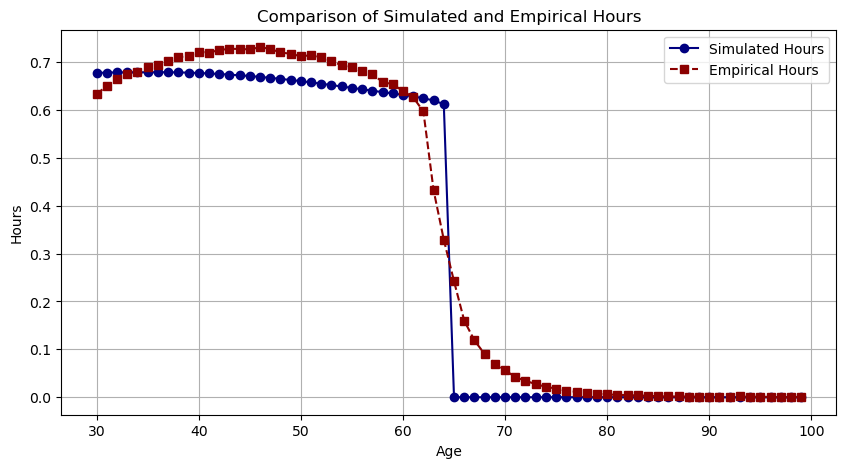

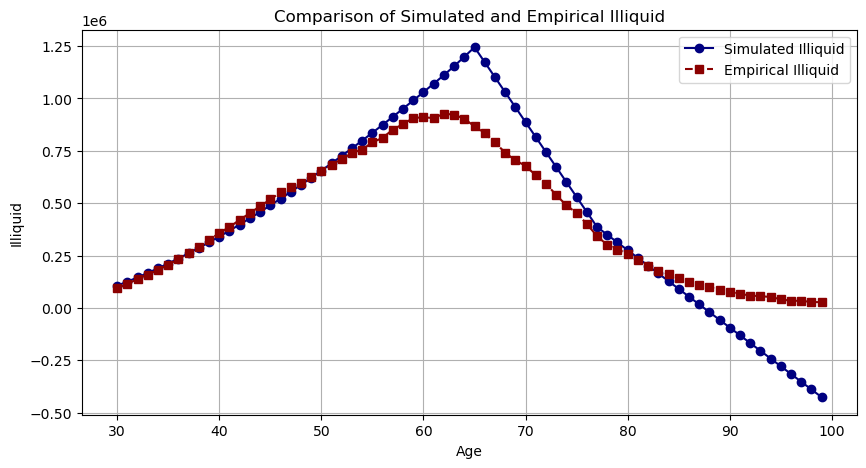

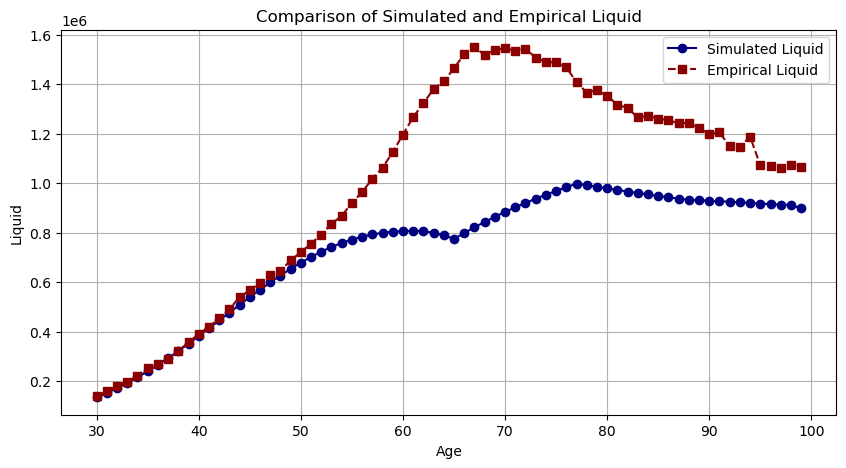

In [12]:
# plot the graph with calibrated values 
a_dict = {
    'hours': [np.mean(model.sim.h, axis=0), moments['hours']],
    'illiquid': [np.mean(model.sim.s, axis=0), moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0), moments['assets']]
}

# Define colors
simulated_color = "navy"  # Dark blue
empirical_color = "darkred"  # Dark red
ci_color = "lightcoral"  # Light red for confidence bands

for key, (simulated, empirical) in a_dict.items():
    plt.figure(figsize=(10, 5))
    
    x_vals = np.arange(len(empirical)) + par.start_age
    
    plt.plot(x_vals, simulated, label=f"Simulated {key.capitalize()}", marker="o", color=simulated_color)
    plt.plot(x_vals, empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s", color=empirical_color)

    # # 99.9% confidence interval
    # ci = std_dev
    # plt.fill_between(x_vals, empirical - ci, empirical + ci, color=ci_color, alpha=0.4, label="Empirical Standard Deviation")

    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()
